In [1]:
import optuna
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import pytorch_lightning as pl

from sklearn.utils import resample
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay

from models.resnet import ResNet

In [2]:
X = pd.read_csv("data/train_preproc.csv").drop(columns=['Unnamed: 0'])
y = pd.read_csv("data/y_train.csv").drop(columns=['Unnamed: 0'])

X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=1,
    )

In [3]:
def prepare_dataloaders(X: pd.DataFrame, 
                        y: pd.DataFrame, 
                        test_size: float = 0.2, 
                        seed: int = 1, 
                        batch_size: int = 128):

    X_train, X_val, y_train, y_val = train_test_split(
        X, y, test_size=test_size, random_state=seed,
    )

    X_train = torch.from_numpy(X_train.values.astype(np.float32)).float()
    y_train = torch.from_numpy(y_train.values.astype(np.float32)).float().squeeze(-1)

    X_val = torch.from_numpy(X_val.values.astype(np.float32)).float()
    y_val = torch.from_numpy(y_val.values.astype(np.float32)).float().squeeze(-1)

    train_dataset = TensorDataset(X_train, y_train)
    val_dataset = TensorDataset(X_val, y_val)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=27)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, num_workers=27)

    return train_loader, val_loader

In [8]:
def fit(X: pd.DataFrame, y: pd.DataFrame, params: dict = {}, seed: int = None):
    train_loader, val_loader = prepare_dataloaders(X, y)

    model = ResNet(X.shape[1], params)

    trainer = pl.Trainer(
        max_epochs=50,

        callbacks=[
            pl.callbacks.EarlyStopping(monitor='val_f1', mode='max', patience=15, min_delta=1e-4),
            pl.callbacks.ModelCheckpoint(save_top_k=1, monitor="val_f1", mode="max"),
        ],
        accelerator="auto",
        enable_checkpointing=True,
        logger=True
    )

    trainer.fit(model, train_loader, val_loader)

    return model

def predict(model: torch.nn.Module, X_test: np.ndarray) -> np.ndarray:

    model.eval()
    test_loader = DataLoader(torch.from_numpy(X_test.values.astype(np.float32)).float(),batch_size=2000)

    predictions = []
    with torch.no_grad():
        for x in test_loader:
            y_pred = model(x)
            predictions.append(y_pred.cpu().numpy())
            
    return np.concatenate(predictions)

def compute_metric(labels, predicted_labels_proba, threshold=0.5):
    predicted_labels = (predicted_labels_proba >= threshold).astype(np.int8)
    return f1_score(labels, predicted_labels)

In [ ]:
def fit_and_test(X, y, train_index, test_index, config = None) -> float:
    X_train_ = X.loc[train_index,:]
    X_test_ = X.loc[test_index,:]
    y_train_ = y.loc[train_index, :]
    y_test_ = y.loc[test_index, :]

    model = fit(X_train_, y_train_, config)
    pred_proba = predict(model, X_test_)
    
    return compute_metric(y_test_, pred_proba)

def objective(trial):
    config = {
        'learning_rate': trial.suggest_float('learning_rate', 1e-3, 0.1,log=True),
        'weight_decay': trial.suggest_float('weight_decay', 1e-6, 1e-2,log=True),
        'n_hidden':trial.suggest_int('n_hidden', 2, 5),
        'layer_size': trial.suggest_int('layer_size', 8, 512, log=True),
        'batch_size': trial.suggest_int('batch_size', 32, 2048, log=True),
        'normalization': trial.suggest_categorical('normalization', choices=['layer_norm']),#'batch_norm']),
        'dropout': trial.suggest_categorical('dropout', choices=['dropout', 'dropout1d']),
        'activation': trial.suggest_categorical('activation', choices=['relu', 'gelu']), 
        'use_scheduler': trial.suggest_categorical('use_scheduler', choices=['True', 'False']), 
        'hidden_factor': trial.suggest_float('hidden_factor', 1, 4),
        'hidden_dropout': trial.suggest_float('hidden_dropout', 0, 0.5),
        'residual_dropout': trial.suggest_float('residual_dropout', 0, 0.5),
    }

    X_train = pd.read_csv("data/train_preproc.csv").drop(columns=['Unnamed: 0'])
    y_train = pd.read_csv("data/y_train.csv").drop(columns=['Unnamed: 0'])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=1)

    scores = []
    for i,(train_index,test_index) in enumerate(cv.split(X_train, y_train)):

        f1_score = fit_and_test(X_train, y_train, train_index, test_index, config)
        scores.append(f1_score)
    
    return np.mean(scores)

study = optuna.create_study(directions=['maximize'], study_name='mlp')
study.optimize(objective, n_trials=50) 

In [6]:
best_params = {'learning_rate': 0.006868056303589185, 
    'weight_decay': 6.898917214573194e-05, 
    'n_hidden': 4, 
    'layer_size': 14, 
    'batch_size': 234, 
    'normalization': 'layer_norm', 
    'dropout': 'dropout', 
    'activation': 'relu', 
    'use_scheduler': 'True', 
    'hidden_factor': 3.393384587761709, 
    'hidden_dropout': 0.05306977286016662, 
    'residual_dropout': 0.26162639347698424}

In [9]:
model = fit(X_train, y_train, best_params)
 
predictions = predict(model, X_test)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name       | Type          | Params | Mode 
-----------------------------------------------------
0 | loss       | BCELoss       | 0      | train
1 | f1         | BinaryF1Score | 0      | train
2 | activation | ReLU          | 0      | train
3 | blocks     | Sequential    | 6.3 K  | train
4 | prediction | Sequential    | 43     | train
-----------------------------------------------------
6.4 K     Trainable params
0         Non-trainable params
6.4 K     Total params
0.025     Total estimated model params size (MB)
41        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
f1 = compute_metric(y_test, predictions)
f1

0.8301886792452831

In [ ]:
n_ensemble = 5
threshold = 0.5
predictions_list = []

X_y = X_train.join(y_train)

for i in range(n_ensemble):
    seed = n_ensemble * i
    df_resampled = resample(X_y, replace=False, random_state=seed)

    target = df_resampled["Grade"]
    train = df_resampled.drop("Grade", axis=1)

    model = fit(train, target, best_params, seed=seed)
    pred_proba = predict(model, X_test)
    
    predictions_list.append(pred_proba)

In [64]:
final_prediction = np.mean(predictions_list, axis=0)
predicted_labels = (final_prediction >= threshold).astype(np.int8)
f1_score(y_test, predicted_labels)

0.822429906542056

<Figure size 800x600 with 0 Axes>

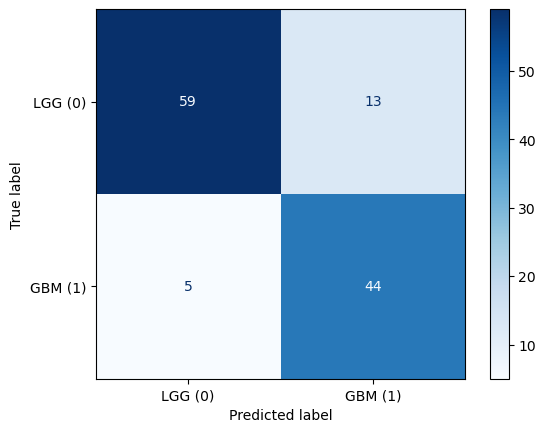

In [11]:
predicted_labels = (predictions >= 0.5).astype(np.int8)
confusion_m = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay(confusion_m, display_labels=['LGG (0)', 'GBM (1)']).plot(cmap='Blues', values_format=".0f")
plt.show();

In [113]:
sub = pd.read_csv("data/sample_submission_file.csv")
sub["Grade"] = predicted_labels
sub.to_csv("data/submission_file.csv", index = False)